In [60]:
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

In [6]:
data = pd.read_csv("temporal_data_with_patient_ready_normalized.csv", index_col=0)
data = data.dropna(axis=0)

columns = data.columns
genes = np.array([name.split("_")[0] for name in list(data.index)])
patients = np.array([name.split("_")[1] for name in list(data.index)])
cells = np.array([name.split("_")[2] for name in list(data.index)])

data

,d0,d1,d2,d5,d9,d15
gene_patient_celltype,,,,,,
TNFRSF18_at_Bcells,-0.431301,-0.316731,0.119736,-0.094728,-0.119979,-0.451895
TNFRSF18_at_CD4memoryactivatedT,-0.451895,0.016902,0.589964,0.694003,0.261909,0.330941
TNFRSF18_at_CD8naiveT,-0.451895,-0.451895,-0.451895,0.334738,-0.451895,-0.451895
TNFRSF18_at_CIKcells,-0.451895,1.904794,0.571058,1.216445,0.256890,-0.203290
TNFRSF18_at_γδTcells,-0.414198,-0.425328,-0.183608,0.077901,-0.057288,-0.451895
...,...,...,...,...,...,...
MT-ND6_rs_CD4memoryT,-0.571980,-0.511746,-0.270021,-0.252244,-0.118303,-1.018894
MT-ND6_rs_CD4naiveT,-0.653688,-0.682944,-0.836094,2.132914,-1.018894,-1.018894
MT-ND6_rs_CIKcells,-0.464631,-0.882725,-1.018894,0.674458,0.315895,0.030211


In [7]:
# set folder with results
results_folder = "hotnet2/paper/results_average"


In [62]:
# list files in results folder
significant_sizes = pd.DataFrame(columns=["shapelet", "delta", "size", "pval", "subnetwork"])

for shapelet in os.listdir(results_folder):
  # iterate over every delta in shapelet
  for delta in os.listdir(os.path.join(results_folder, shapelet)):
    if os.path.isdir(os.path.join(results_folder, shapelet, delta)):
      significance_file = os.path.join(results_folder, shapelet, delta, "results.json")
      
      with open(significance_file) as f:
        results_json = json.load(f)
        max_size = max(map(int, results_json['statistics'].keys()))

        for size in results_json['statistics'].keys():
          pval = results_json['statistics'][size]['pval']
          significant_subnetworks = []

          if pval < 0.05:

            for subnetwork in results_json['components']:
              if len(subnetwork) == int(size):
                significant_subnetworks.append(subnetwork)
              if len(subnetwork) > int(size) and max_size == int(size):
                significant_subnetworks.append(subnetwork)
            
            # plot significant subnetworks based on data and genes
            # Create a PdfPages object
            with PdfPages('plots/significant_subnetworks_plots_' + shapelet + '_size_' + size + '.pdf') as pdf:
              # get data rows corresponding to the first significant subnetwork

              for genes_list in significant_subnetworks:
                # Define the list of genes

                # Filter rows where the index contains any of the genes in the list and "CIKcells"
                filtered_data = data[data.index.str.contains("CIKcells") & data.index.str.contains('|'.join(genes_list))]

                # Modify index to include only gene names
                filtered_data.index = [next(gene for gene in genes_list if gene in name) for name in filtered_data.index]

                # Plot the data as lines with color coding based on genes
                plt.figure(figsize=(10, 5))
                sns.lineplot(data=filtered_data.T, dashes=False)
                plt.title(f'Pvalues: {pval}')
                pdf.savefig()  # Save the current figure into the pdf
                plt.close()  # Close the figure to avoid displaying it in the notebook

            significant_sizes = pd.concat([significant_sizes, 
                                          pd.DataFrame([{"shapelet": shapelet, 
                                            "delta": delta, 
                                            "size": size, 
                                            "pval": pval,
                                            "subnetwork": significant_subnetworks}])], ignore_index=True)

# group significant sizes by shapelet and by delta, and keep the delta with the highest number of significant sizes
significant_sizes = significant_sizes.sort_values(by=["shapelet", "delta", "size"], ascending=True)
significant_sizes = significant_sizes.groupby(["shapelet", "delta"]).first().reset_index()
          

/tmp/ipykernel_1363579/3402975586.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  significant_sizes = pd.concat([significant_sizes,
/tmp/ipykernel_1363579/3402975586.py:28: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  with PdfPages('plots/significant_subnetworks_plots_' + shapelet + '_size_' + size + '.pdf') as pdf:
/tmp/ipykernel_1363579/3402975586.py:28: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  with PdfPages('plots/significant_subnetworks_plots_' + shapelet + '_size_' + size + '.pdf') as pdf:
/tmp/ipykernel_1363579/3402975586.py:28: MatplotlibDeprecationWarning: Keeping empty pdf files is

In [11]:
significant_sizes

,shapelet,delta,size,pval,subnetwork
0,hint+hi2012-scores_row_1,delta_1.6389133828826407e-06,3,0.003,"[[ATF5, CEBPB, CEBPD], [CCNA2, MYBL2, RBL1], [..."
1,hint+hi2012-scores_row_10,delta_3.9919920169554226e-07,3,0.039,"[[CD63, CD9, HBEGF], [CD79A, CD79B, FCAR], [CD..."
2,hint+hi2012-scores_row_10,delta_9.354287342066385e-07,3,0.000,"[[AFF3, MCM6, MLLT3], [ANXA1, FAF1, S100A11], ..."
3,hint+hi2012-scores_row_11,delta_3.809983830512145e-06,6,0.032,"[[BCL2, BCL2A1, BCL2L11, PMAIP1, PPP3CA, RCAN2..."
4,hint+hi2012-scores_row_12,delta_1.7545828384836354e-06,4,0.011,"[[ACP5, EGR2, TNFRSF10B, TNFSF10], [AURKA, AUR..."
...,...,...,...,...,...
72,hint+hi2012-scores_row_69,delta_2.981906584739081e-07,3,0.007,"[[ACP5, EGR2, TNFSF10], [ARL6IP1, PBX3, SNX10]..."
73,hint+hi2012-scores_row_69,delta_6.037407344443359e-07,4,0.022,"[[CAPG, NCAPH, SMC2, SMC4], [EIF2AK3, FCHSD2, ..."
74,hint+hi2012-scores_row_72,delta_1.0789596396390997e-07,7,0.019,"[[CD74, CST7, HLA-DMA, HLA-DMB, HLA-DRA, HLA-D..."
75,hint+hi2012-scores_row_72,delta_2.0834667724859207e-07,6,0.029,"[[CD74, HLA-DMA, HLA-DMB, HLA-DRA, HLA-DRB1, H..."


### Plot

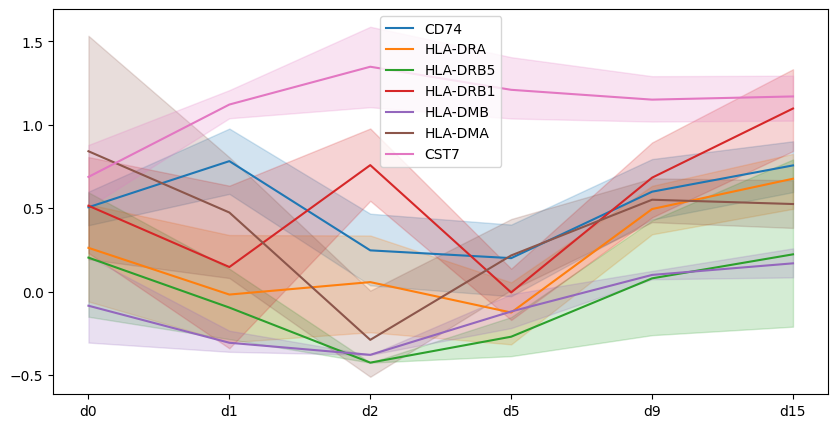

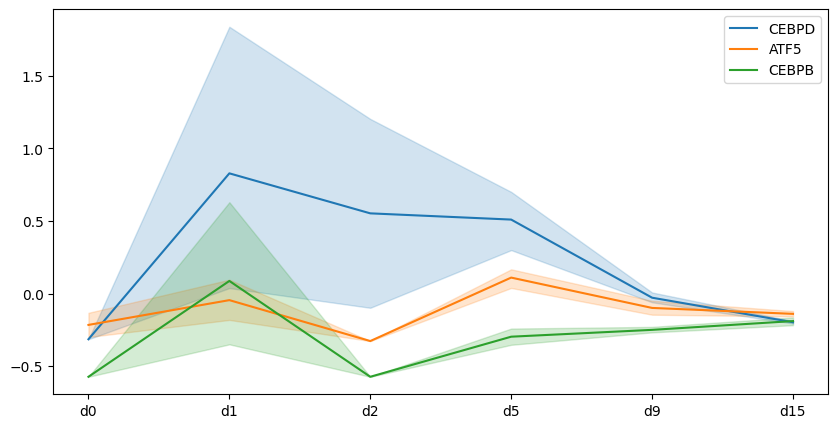